In [1]:
import networkx as nx

from regraph import Rule, plot_rule
from regraph.neo4j.graphs import Neo4jGraph
from regraph.neo4j.cypher_utils import *

In [2]:
g = Neo4jGraph("bolt://localhost:7687", "neo4j", "admin")

In [3]:
res = g.clear()

In [4]:
nodes = ["a", "b", "c", "d", "e", "f"]
edges = [("a", "b"), ("d", "b"), ("a", "c"), ("e", "a"), ("f", "d")]
g.add_nodes_from(nodes)
g.add_edges_from(edges)

 OPTIONAL MATCH (same_id_node:node) WHERE same_id_node.id = 'a' FOREACH(new_count IN CASE WHEN same_id_node IS NOT NULL THEN [coalesce(same_id_node.count, 0) + 1] ELSE [] END | SET same_id_node.count = new_count) WITH same_id_node  UNWIND CASE WHEN same_id_node IS NOT NULL THEN ['a' + same_id_node.count] ELSE ['a'] END AS new_id_a CREATE (a:node { id : new_id_a }) 
 OPTIONAL MATCH (same_id_node:node) WHERE same_id_node.id = 'b' FOREACH(new_count IN CASE WHEN same_id_node IS NOT NULL THEN [coalesce(same_id_node.count, 0) + 1] ELSE [] END | SET same_id_node.count = new_count) WITH same_id_node  UNWIND CASE WHEN same_id_node IS NOT NULL THEN ['b' + same_id_node.count] ELSE ['b'] END AS new_id_b CREATE (b:node { id : new_id_b }) 
 OPTIONAL MATCH (same_id_node:node) WHERE same_id_node.id = 'c' FOREACH(new_count IN CASE WHEN same_id_node IS NOT NULL THEN [coalesce(same_id_node.count, 0) + 1] ELSE [] END | SET same_id_node.count = new_count) WITH same_id_node  UNWIND CASE WHEN same_id_node IS

In [5]:
g.add_node("x")

 OPTIONAL MATCH (same_id_node:node) WHERE same_id_node.id = 'x' FOREACH(new_count IN CASE WHEN same_id_node IS NOT NULL THEN [coalesce(same_id_node.count, 0) + 1] ELSE [] END | SET same_id_node.count = new_count) WITH same_id_node  UNWIND CASE WHEN same_id_node IS NOT NULL THEN ['x' + same_id_node.count] ELSE ['x'] END AS new_id CREATE (x:node { id : new_id }) 


In [6]:
g.add_edge("x", "c")

In [7]:
g.remove_edge("x", "c")

In [8]:
g.remove_node("x")

In [9]:
g.nodes()

['e', 'f', 'a', 'b', 'c', 'd']

In [10]:
g.edges()

[('e', 'a'), ('a', 'b'), ('d', 'b'), ('a', 'c'), ('f', 'd')]

In [11]:
res_clone_1 = g.clone_node('a', ignore_naming=True)
print("Created clone by the name: ", res_clone_1)

Created clone by the name:  2010849


In [12]:
res_clone_2 = g.clone_node('a', 'a_clone', ignore_naming=True)
print("Created clone by the name: ", res_clone_2)

Created clone by the name:  2010850


In [13]:
res_merge = g.merge_nodes(["a", "b"])

 OPTIONAL MATCH (same_id_node:node) WHERE same_id_node.id = 'a_b' FOREACH(new_count IN CASE WHEN same_id_node IS NOT NULL THEN [coalesce(same_id_node.count, 0) + 1] ELSE [] END | SET same_id_node.count = new_count) WITH same_id_node , sucs_b, sucs_a, preds_b, a, b, preds_a UNWIND CASE WHEN same_id_node IS NOT NULL THEN ['a_b' + same_id_node.count] ELSE ['a_b'] END AS new_id CREATE (merged_node:node { id : new_id }) 


In [14]:
res_merge

'a_b'

In [15]:
pattern = nx.DiGraph()
pattern.add_nodes_from(["x", "y", "z", "a"])
pattern.add_edges_from([("x", "y"), ("y", "z"), ("z", "z"), ("z", "a")])

In [16]:
instances = g.find_matching(pattern)
print("Instances: ", instances)

Instances:  [{'x': 'e', 'y': '2010849', 'z': 'a_b', 'a': 'c'}, {'x': 'e', 'y': '2010850', 'z': 'a_b', 'a': 'c'}, {'x': 'f', 'y': 'd', 'z': 'a_b', 'a': 'c'}]


In [17]:
rule = Rule.from_transform(pattern)
clone_name1, _ = rule.inject_clone_node("y")
clone_name2, _ = rule.inject_clone_node("y")
rule.inject_remove_edge(clone_name2, "z")
rule.inject_remove_node("x")
rule.inject_merge_nodes(["y", "a"])
rule.inject_add_node("new_node")
rule.inject_add_edge("new_node", "z")

/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


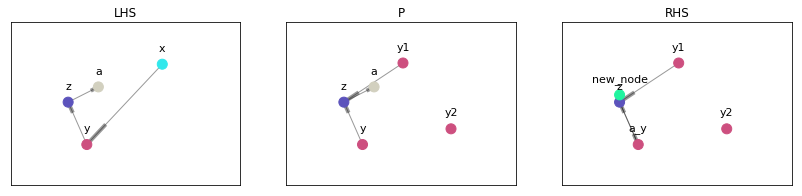

In [18]:
plot_rule(rule)

In [19]:
instances[0]

{'a': 'c', 'x': 'e', 'y': '2010849', 'z': 'a_b'}

In [20]:
rhs_g = g.rewrite(rule, instances[0])
print("\n\nRewriting rule to commands: \n")
print(rule.to_commands())

CREATE (uidce7fe4440dae4e7690034edbe9cd9027:node) SET uidce7fe4440dae4e7690034edbe9cd9027.id=toString(id(uidce7fe4440dae4e7690034edbe9cd9027)) WITH toString(id(uidce7fe4440dae4e7690034edbe9cd9027)) as uid9a73e63df741406b952cf43942921789 , sucs_uiddbd81bd0cd784f048726112c1c8695b8, preds_uiddbd81bd0cd784f048726112c1c8695b8, uid5fc9eaa93f974b63a7410f900e21927d, uidce7fe4440dae4e7690034edbe9cd9027, preds_uid5fc9eaa93f974b63a7410f900e21927d, uid7da307c8957a4b89bf8a2c96baa73ffb, uiddbd81bd0cd784f048726112c1c8695b8, uid144cc858d54e4150bbd9a94fb201da64, uidee0e3e53faf64b6588fd910c1a7b9110, sucs_uid5fc9eaa93f974b63a7410f900e21927d 
CREATE (uid646bea82abdb479db70d0f26a5946e4d:node) SET uid646bea82abdb479db70d0f26a5946e4d.id=toString(id(uid646bea82abdb479db70d0f26a5946e4d)) WITH toString(id(uid646bea82abdb479db70d0f26a5946e4d)) as uid2a74c412e4994ad38f56e71780513510 , uid646bea82abdb479db70d0f26a5946e4d, uidce7fe4440dae4e7690034edbe9cd9027, uid9a73e63df741406b952cf43942921789, uid7da307c8957a4b89

In [21]:
rhs_g

{'a_y': '2010854',
 'new_node': '2010855',
 'y1': '2010853',
 'y2': '2010852',
 'z': 'a_b'}

In [22]:
pattern.edges()

[('x', 'y'), ('y', 'z'), ('z', 'z'), ('z', 'a')]

In [23]:
pattern = nx.DiGraph()
pattern.add_edge("x", "y")

rule = Rule.from_transform(pattern)
rule.inject_merge_nodes(["x", "y"])

'x_y'

/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


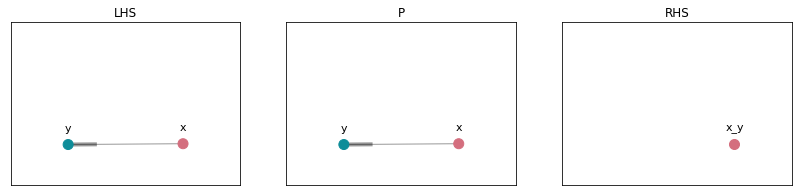

In [24]:
plot_rule(rule)

In [25]:
rhs = g.rewrite(rule, {"x": "f", "y": "d"})

CREATE (uid722dd37a9ec44d64a3bb425ef48455bf:node) SET uid722dd37a9ec44d64a3bb425ef48455bf.id=toString(id(uid722dd37a9ec44d64a3bb425ef48455bf)) WITH toString(id(uid722dd37a9ec44d64a3bb425ef48455bf)) as uid3b2510e0b12942d4bb7e97743bfe3dc0 , uid722dd37a9ec44d64a3bb425ef48455bf, preds_uid9222c226afd94d9a887d9d76bcc0ce84, sucs_uidd58c9e0988e74921a646062e35821cec, uidd58c9e0988e74921a646062e35821cec, uid9222c226afd94d9a887d9d76bcc0ce84, preds_uidd58c9e0988e74921a646062e35821cec, sucs_uid9222c226afd94d9a887d9d76bcc0ce84 


In [26]:
rhs

{'x_y': '2010857'}

In [4]:
pattern = nx.DiGraph()
pattern.add_edges_from(
    [
        ("white_circle", "square"),
        ("square", "black_circle"),
        ("triangle", "square")
    ])

In [5]:
ex_rule = Rule.from_transform(pattern)
ex_rule.inject_remove_node("traingle")
ex_rule.inject_clone_node("square")
ex_rule.inject_merge_nodes(["white_circle", "black_circle"])

'black_circle_white_circle'

/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


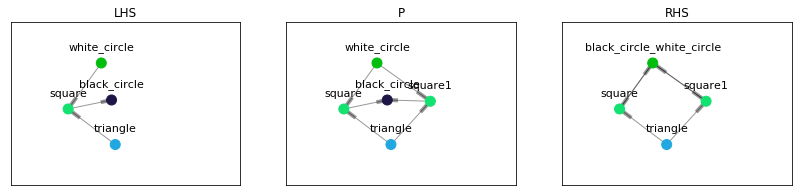

In [6]:
plot_rule(ex_rule)